In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Biblioteca para identificar os sinais, os indices dos complexos QRS e
# as anotacoes nos bancos de dados do MIT
import wfdb
from wfdb import processing

import math
import pywt
import pandas as pd
import numpy as np
from numpy import *
from numpy import load
import scipy.io as sio
import numpy.matlib 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import signal
from os import listdir
from numpy.linalg import inv,pinv
from numpy.linalg import eig

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.interpolate import interp1d
from sklearn import covariance
from sklearn.utils import class_weight

import datetime
import json
import seaborn as sn
import pandas as pd

# Importacao do arquivo contendo funcoes de pre-processamento,
# segmentacao e divisao do banco de dados
import import_ipynb
from SeparacaoAAMI import *

# Fixando as seeds
import random
random.seed(21)
np.random.seed(21)
seed_value= 3016
tf.random.set_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

%matplotlib inline

importing Jupyter notebook from SeparacaoAAMI.ipynb


# Divisão dos dados e Pré-Processamento

In [2]:
fs = 360 # Freq. de amostragem do sinal
pasta = 'mit-bih-arrhythmia-database-1.0.0/'

# Divisao seguindo Chazal et al. (2004)
DS1 = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119', '122', '124', '201', '203', '205', '207', '208', '209', '215', '220', '223', '230']
DS2 = ['100', '103', '105', '111', '113', '117', '121', '123', '200', '202', '210', '212', '213', '214', '219', '221', '222', '228', '231', '232', '233', '234']

# Divisao dos dados nas classes da AAMI
N = ['N', 'L', 'R', 'e', 'j']
S = ['A', 'a', 'J', 'S']
V = ['V', 'E']
F = ['F']
Q = ['/', 'f', 'Q']
nonbeat = ['[', ']', '!', 'x', '|', '~', '+', '"'] #nao pertencem a nenhuma das classes

# Importacao das localizacoes dos complexos QRS corrigidas, ou seja,
# das localizacoes seguindo as anotacoes, dados os simbolos que foram
# identificados pelo ecg-kit (MATLAB)

with open('simbolos_versaofinal.json', 'r') as json_file:
    simbolos = json.load(json_file)

In [3]:
periodo = 320 # numero aproximado de amostras em um batimento 

# Modo de entrada para obter tanto as 960 amostras do sinal quanto as
# caracteristicas extraidas seguindo Chazal
modo = 'MI' 

# Sem normalizacao do sinal
norm = False

# Mother-wavelet e nivel de decomposicao
wavFunc = 'db2'
level = 4

# Numero de classes do problema e numero de blocos LSTM (se for uma rede RNN)
numclass = 4
blocosLSTM = 3

# Probabilidades marginais da LDA
pi = np.repeat(1/numclass, numclass)

# Divisao dos pacientes em dados de treinamento e dados de teste
# da primeira derivacao (indice 0) e da segunda derivacao (indice 1).
# X_train0_all corresponde a todo o numero de dados disponivel da
# primeira derivacao para o treinamento. X_train0_all_chazal corresponde
# a todo o numero de dados disponivel das caracteristicas extraidas,
# seguindo Chazal, da primeira derivacao para o treinamento. 
# Y_train_int_all representa as classes verdadeiras dos dados, em inteiros 
# (k = 0 corresponde a classe N, k = 1 corresponde a classe S...).
# Sym_train contem os simbolos dos batimentos de treinamento e
# Patient_train contem os pacientes em que eles ocorrem.

X_train0_all, X_train1_all, X_train0_all_chazal, X_train1_all_chazal, Y_train_int_all, Sym_train, Patient_train = dataset(pasta, DS1, periodo, fs, simbolos, modo, norm, wavFunc, level, 'NSVF', blocosLSTM)
X_test0_all, X_test1_all, X_test0_all_chazal, X_test1_all_chazal, Y_test_int_all, Sym_test, Patient_test = dataset(pasta, DS2, periodo, fs, simbolos, modo, norm, wavFunc, level, 'NSVF', blocosLSTM)

In [4]:
def eq_dataset(df, DS, numclass):
    # Funcao para selecionar aleatoriamente, mas respeitando
    # a divisao dos pacientes, os dados de cada classe de modo 
    # a equilibrar a quantidade de exemplos em cada. Nao corresponde
    # a uma boa selecao de entrada no cenario realista, pois reduz muito o numero
    # de dados disponiveis, sendo usada somente para testes e para 
    # verificar problemas que nao sao associados ao desbalanceamento.
    # Foi feita de modo que nenhum paciente fosse excluido e que batimentos
    # selecionados de um mesmo paciente nao fossem consecutivos.
    # Retorna o indice dos dados selecionados.
    num = 372
    num_pat = len(DS) # numero de pacientes
    ind_eq = []
    for i in DS:
        for j in range(numclass):
            ind = df.index[(df['Y'] == j) & (df['Paciente'] == i)].tolist()
            if (size(ind) > 0) and isin(j, [3]):
                ind_eq = np.concatenate([ind_eq, ind])
            elif (size(ind) > 0) and isin(j, [0]):
                ind_eq = np.concatenate([ind_eq, random.sample(ind, int(np.floor(num/(num_pat))))])
            elif (size(ind) > 0) and (isin(j, [2])) and (size(ind) > 8*int(np.floor(num/num_pat))):
                ind_eq = np.concatenate([ind_eq, random.sample(ind, int(np.floor(num/(num_pat*1.4))))])
            elif (size(ind) > 0) and (size(ind) > 12*int(np.floor(num/num_pat))):
                ind_eq = np.concatenate([ind_eq, random.sample(ind, int(np.floor(num/(num_pat*1.1))))])
            elif (size(ind) > 0):
                ind_eq = np.concatenate([ind_eq, ind])
    return ind_eq

def dim_N_dataset(df, DS, numclass):
    # Funcao para selecionar os dados usando todos os exemplos das classes
    # S, V, F e Q, e diminuindo o numero de dados da classe N.
    # Foi feita de modo que nenhum paciente fosse excluido e que batimentos
    # selecionados de um mesmo paciente nao fossem consecutivos.
    # Retorna o indice dos dados selecionados.
    num = 8500
    num_pat = len(DS) # numero de pacientes
    ind_eq = []
    for i in DS:
        for j in range(numclass):
            ind = df.index[(df['Y'] == j) & (df['Paciente'] == i)].tolist()
            if (size(ind) > 0) and isin(j, [0]) and (size(ind) > 1.5*int(np.floor(num/num_pat))):
                ind_eq = np.concatenate([ind_eq, random.sample(ind, int(np.floor(num/(num_pat))))])
            elif (size(ind) > 0):
                ind_eq = np.concatenate([ind_eq, ind])
    return ind_eq


#################### Quantidade de dados utilizados ######################
########## Todos as classes com aproximadamente o mesmo numero ###########
# df_train = pd.DataFrame({'Paciente': Patient_train, 'Y': Y_train_int_all.flatten().astype('int32')})
# df_test = pd.DataFrame({'Paciente': Patient_test, 'Y': Y_test_int_all.flatten().astype('int32')})
# ind_train = [int(i) for i in eq_dataset(df_train, DS1, 4)]
# ind_test = [int(i) for i in eq_dataset(df_test, DS2, 4)]
# X_train0, X_train1, Y_train_int = take_ind(ind_train, X_train0_all, X_train1_all, Y_train_int_all)
# X_test0, X_test1, Y_test_int = take_ind(ind_test, X_test0_all, X_test1_all, Y_test_int_all)

###################### Todos os dados disponiveis ####################
# X_train0, X_train1, Y_train_int = X_train0_all, X_train1_all, Y_train_int_all
# X_test0, X_test1, Y_test_int = X_test0_all, X_test1_all, Y_test_int_all

###### Diminuicao dos dados de N e todos os dados disponiveis das outras ########
df_train = pd.DataFrame({'Paciente': Patient_train, 'Y': Y_train_int_all.flatten().astype('int32')})
df_test = pd.DataFrame({'Paciente': Patient_test, 'Y': Y_test_int_all.flatten().astype('int32')})
ind_train = [int(i) for i in dim_N_dataset(df_train, DS1, 4)]
ind_test = [int(i) for i in dim_N_dataset(df_test, DS2, 4)]
X_train0, X_train1, Y_train_int = take_ind(ind_train, X_train0_all, X_train1_all, Y_train_int_all)
X_test0, X_test1, Y_test_int = take_ind(ind_test, X_test0_all, X_test1_all, Y_test_int_all)
X_train0_chazal, X_train1_chazal, Y_train_int = take_ind(ind_train, X_train0_all_chazal, X_train1_all_chazal, Y_train_int_all)
X_test0_chazal, X_test1_chazal, Y_test_int = take_ind(ind_test, X_test0_all_chazal, X_test1_all_chazal, Y_test_int_all)


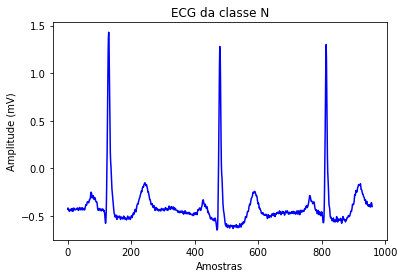

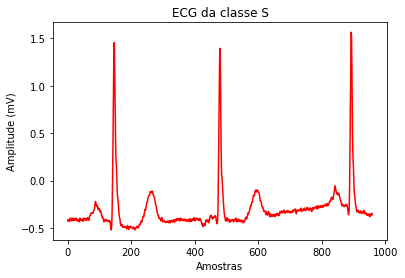

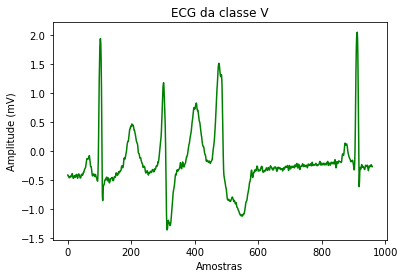

In [5]:
# Plot dos sinais de cada classe
id1 = np.where(Y_train_int == 0)[0][0]
id2 = np.where(Y_train_int == 1)[0][1]
id3 = np.where(Y_train_int == 2)[0][0]
id4 = np.where(Y_train_int == 3)[0][0]
# id5 = np.where(Y_train_int == 4)[0][0]
plt.rcParams.update({'font.size': 10})
# Plot das 3 classes. Plot das 5 classes poderia ser feito com funcao 'plotECG()'
plotECG_NSV(False, X_train0, id1, id2, id3)

In [6]:
# Obtencao dos pesos das classes
Y_train_flat = Y_train_int.flatten()
pesos = class_weight.compute_class_weight(class_weight = 'balanced', classes=np.unique(Y_train_flat),  y=Y_train_flat)
pesos = pesos*10
pesos = list(map(math.ceil,pesos))
pesos = {i: pesos[i] for i in range(np.size(pesos))}

# Codificacao 1 entre m (Classe N, por exemplo, é [1,0,0,0,0])
Y_train = onehot(X_train0, Y_train_int, numclass)
Y_test = onehot(X_test0, Y_test_int, numclass)

# Mudanca no tamanho dos vetores para um LSTM de 320 amostras de entrada e 3 passos de tempo 
X_train_RNN0 = np.reshape(X_train0, (X_train0.shape[0], blocosLSTM, X_train0.shape[1]//blocosLSTM))
X_test_RNN0 = np.reshape(X_test0, (X_test0.shape[0], blocosLSTM, X_test0.shape[1]//blocosLSTM))
X_train_RNN1 = np.reshape(X_train1, (X_train1.shape[0], blocosLSTM, X_train1.shape[1]//blocosLSTM))
X_test_RNN1 = np.reshape(X_test1, (X_test1.shape[0], blocosLSTM, X_test1.shape[1]//blocosLSTM))

# Concatenacao com split para usar dados de teste como validacao e evitar perda de exemplos
split = X_test0.shape[0]/(X_test0.shape[0] + X_train0.shape[0])
all_X0 = np.concatenate((X_train_RNN0, X_test_RNN0), axis = 0)
all_X1 = np.concatenate((X_train_RNN1, X_test_RNN1), axis = 0)
all_label = np.concatenate((Y_train, Y_test), axis = 0)
all_X0.shape

(24266, 3, 320)

# Classificadores

## LDA

-------------------------Treino------------------------
[[6855  547  298  792]
 [  86  567   59   41]
 [ 102  223 1976  236]
 [  18    1   15  362]]
              precision    recall  f1-score   support

         0.0     0.9708    0.8072    0.8815      8492
         1.0     0.4238    0.7530    0.5423       753
         2.0     0.8416    0.7789    0.8090      2537
         3.0     0.2530    0.9141    0.3963       396

    accuracy                         0.8014     12178
   macro avg     0.6223    0.8133    0.6573     12178
weighted avg     0.8867    0.8014    0.8296     12178

-------------------------Teste------------------------
[[6684  425  176 1074]
 [ 223  536  387  173]
 [  60  669 1036  269]
 [ 195    3    4  174]]
              precision    recall  f1-score   support

         0.0     0.9333    0.7996    0.8613      8359
         1.0     0.3282    0.4064    0.3631      1319
         2.0     0.6463    0.5093    0.5697      2034
         3.0     0.1030    0.4628    0.1684       3

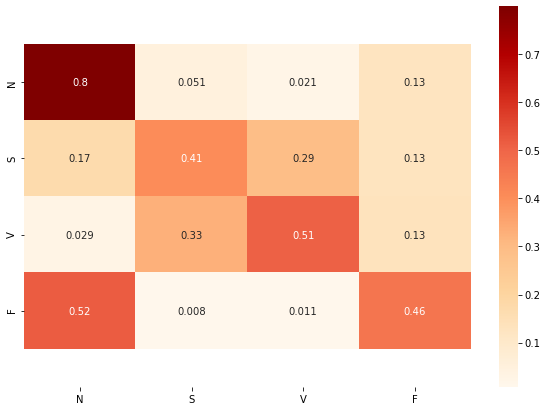

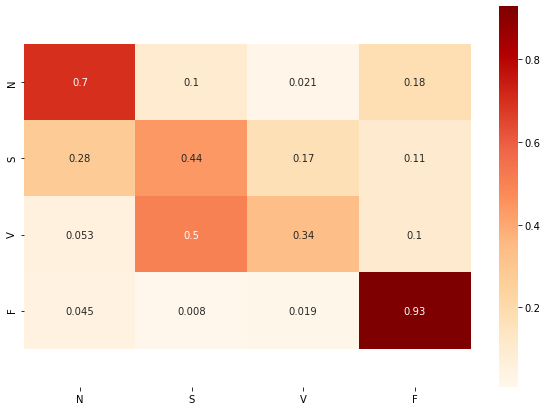

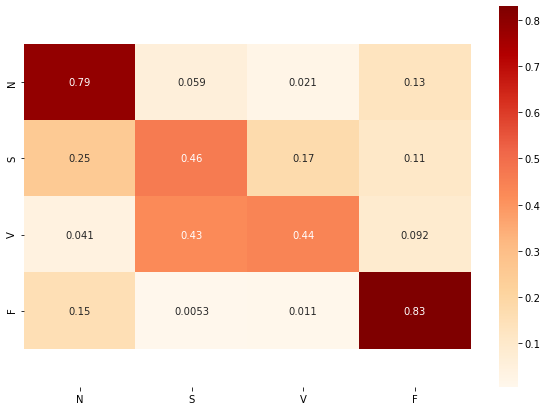

In [7]:
# LDA da primeira derivacao com extracao de caracteristicas de Chazal como entrada
lda0 =  LinearDiscriminantAnalysis(n_components=None, solver='eigen', priors= pi, covariance_estimator=covariance.EmpiricalCovariance())
lda0 = lda0.fit(X_train0_chazal, Y_train_int.flatten())
Y_train_preds0 = lda0.predict_proba(X_train0_chazal)
Y_test_preds0 = lda0.predict_proba(X_test0_chazal)
Y_train_proj0 = lda0.transform(X_train0_chazal)
Y_test_proj0 = lda0.transform(X_test0_chazal)

# LDA da segunda derivacao com extracao de caracteristicas de Chazal como entrada
lda1 =  LinearDiscriminantAnalysis(n_components=None, solver='eigen',  priors= pi, covariance_estimator=covariance.EmpiricalCovariance())
lda1 = lda1.fit(X_train1_chazal, Y_train_int.flatten())
Y_train_preds1 = lda1.predict_proba(X_train1_chazal)
Y_test_preds1 = lda1.predict_proba(X_test1_chazal)
Y_train_proj1 = lda1.transform(X_train1_chazal)
Y_test_proj1 = lda1.transform(X_test1_chazal)

# Matrizes de confusao das LDAs
M0_lda = resultados(Y_train_int, np.argmax(Y_train_preds0, axis=1), Y_test_int, np.argmax(Y_test_preds0, axis=1), numclass)
M1_lda = resultados(Y_train_int, np.argmax(Y_train_preds1, axis=1), Y_test_int, np.argmax(Y_test_preds1,axis=1), numclass)

##### Combinacao dos classificadores das duas derivacoes 
Y_train_preds_lda = combiner2(Y_train_preds0, Y_train_preds1)
Y_test_preds_lda = combiner2(Y_test_preds0, Y_test_preds1)
M_lda = resultados(Y_train_int, np.argmax(Y_train_preds_lda, axis=1), Y_test_int, np.argmax(Y_test_preds_lda,axis=1), numclass)

## RNN

-------------------------Treino------------------------
[[8389   95    0    8]
 [   0  753    0    0]
 [   0    1 2535    1]
 [   0    0    0  396]]
              precision    recall  f1-score   support

         0.0     1.0000    0.9879    0.9939      8492
         1.0     0.8869    1.0000    0.9401       753
         2.0     1.0000    0.9992    0.9996      2537
         3.0     0.9778    1.0000    0.9888       396

    accuracy                         0.9914     12178
   macro avg     0.9662    0.9968    0.9806     12178
weighted avg     0.9923    0.9914    0.9916     12178

-------------------------Teste------------------------
[[6632  777  616  334]
 [ 560  731   24    4]
 [ 370   19 1577   68]
 [ 294    7   18   57]]
              precision    recall  f1-score   support

         0.0     0.8442    0.7934    0.8180      8359
         1.0     0.4765    0.5542    0.5124      1319
         2.0     0.7056    0.7753    0.7388      2034
         3.0     0.1231    0.1516    0.1359       3

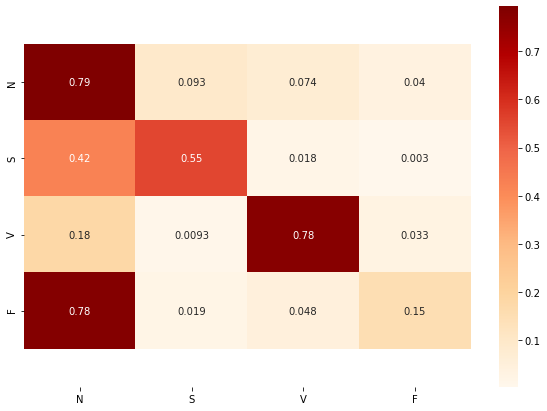

In [8]:
# Fixar novamente a seed!
random.seed(21)
np.random.seed(21)
seed_value= 3016
tf.random.set_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Hiperparametros e Algoritmo de otimizacao
nepochs = 100
nunits = 72
adam = tf.keras.optimizers.Adam(learning_rate= 0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-07)
initializer = tf.keras.initializers.GlorotUniform()
ort_initializer = tf.keras.initializers.Orthogonal()

# Identificacao do modelo no summary e nas metricas impressas no csv
key = str(datetime.datetime.now())

# Estrutura da rede
model0 = keras.Sequential()
model0.add(layers.LSTM(nunits, input_shape=(blocosLSTM, all_X0.shape[2]), return_sequences =False, dropout=0, recurrent_dropout=0.0, kernel_initializer=initializer, recurrent_initializer=ort_initializer))
model0.add(layers.Dense(numclass,activation='softmax'))

# Treinamento da rede
model0.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy', tf.keras.metrics.Recall()])
history = model0.fit(all_X0, all_label, shuffle=False, epochs=nepochs, validation_split=split, verbose = False, class_weight=pesos) 
#validationsplit utiliza os ultimos dados de all_X

# Teste da rede
Y_train_preds_rnn = model0.predict(X_train_RNN0, verbose = 0)
Y_test_preds_rnn = model0.predict(X_test_RNN0, verbose = 0)
M0 = resultados(Y_train_int, np.argmax(Y_train_preds_rnn, axis = 1), Y_test_int, np.argmax(Y_test_preds_rnn, axis = 1), numclass)
metricasNSVF(M0, True, r'resultados_rnn_lda.csv', 'LSTM_modelo0', str(modo), str(periodo), str([nunits, numclass]) + ' - drop: [0 0]', nepochs, key)
# tf.keras.utils.plot_model(model0, to_file=key+'.png')

# Salvando o summary do modelo
with open(r'summ_rnn_lda.txt','a') as f:
    print(key, file=f)
model0.summary(print_fn=printsum)

# Limpando a memoria
tf.keras.backend.clear_session()

## Combinação dos classificadores

-------------------------Treino------------------------
[[8361  106   21    4]
 [   2  749    2    0]
 [  14   10 2511    2]
 [   4    1    0  391]]
              precision    recall  f1-score   support

         0.0     0.9976    0.9846    0.9911      8492
         1.0     0.8649    0.9947    0.9253       753
         2.0     0.9909    0.9898    0.9903      2537
         3.0     0.9849    0.9874    0.9861       396

    accuracy                         0.9864     12178
   macro avg     0.9596    0.9891    0.9732     12178
weighted avg     0.9876    0.9864    0.9867     12178

-------------------------Teste------------------------
[[7488  335  125  411]
 [ 462  735  116    6]
 [ 216  239 1497   82]
 [ 214    1    8  153]]
              precision    recall  f1-score   support

         0.0     0.8936    0.8958    0.8947      8359
         1.0     0.5611    0.5572    0.5591      1319
         2.0     0.8574    0.7360    0.7921      2034
         3.0     0.2347    0.4069    0.2977       3

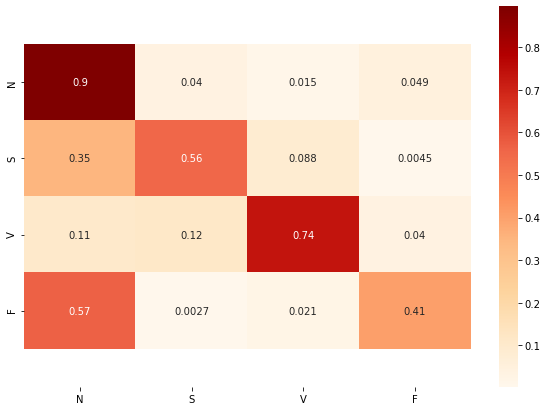

In [9]:
######### Resultados finais da combinacao da RNN com a LDA ########
M = resultados(Y_train_int, np.argmax(combiner2(Y_train_preds_rnn, Y_train_preds_lda), axis=1), Y_test_int,  np.argmax(combiner2(Y_test_preds_rnn, Y_test_preds_lda), axis=1), numclass)
metricasNSVF(M, True, r'resultados_rnn_lda.csv', 'LSTM0_LDA01_combinado', str(modo), str(periodo), str([nunits,numclass]) + ' - drop: [0 0]', nepochs, key)

In [10]:
M

array([[7488,  335,  125,  411],
       [ 462,  735,  116,    6],
       [ 216,  239, 1497,   82],
       [ 214,    1,    8,  153]])

In [11]:
# Salvando o modelo da LDA

# import pickle

# with open('LDA0_Modelo_RNN_LDA', 'wb') as config_dictionary_file:
#     pickle.dump(lda0, config_dictionary_file)
# with open('LDA1_Modelo_RNN_LDA', 'wb') as config_dictionary_file:
#     pickle.dump(lda1, config_dictionary_file)